In [70]:
import pandas as pd
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
from pytrends import dailydata
from functools import reduce
import numpy as np

In [71]:
#Loading google trends data daily
start_year=2014
start_month=1
end_year=2020
end_month=10
keywords=['virus','crisis']
df_list=[]
for keyword in keywords:
    df_tmp = dailydata.get_daily_data(keyword, start_year, start_month, end_year, end_month, geo = 'US')
    df_list.append(df_tmp[keyword].to_frame())

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), df_list)

# 
# pytrends.build_payload(['virus'], cat=0, timeframe='today 5-y', geo='', gprop='')

virus:2014-01-01 2014-01-31
virus:2014-02-01 2014-02-28
virus:2014-03-01 2014-03-31
virus:2014-04-01 2014-04-30
virus:2014-05-01 2014-05-31
virus:2014-06-01 2014-06-30
virus:2014-07-01 2014-07-31
virus:2014-08-01 2014-08-31
virus:2014-09-01 2014-09-30
virus:2014-10-01 2014-10-31
virus:2014-11-01 2014-11-30
virus:2014-12-01 2014-12-31
virus:2015-01-01 2015-01-31
virus:2015-02-01 2015-02-28
virus:2015-03-01 2015-03-31
virus:2015-04-01 2015-04-30
virus:2015-05-01 2015-05-31
virus:2015-06-01 2015-06-30
virus:2015-07-01 2015-07-31
virus:2015-08-01 2015-08-31
virus:2015-09-01 2015-09-30
virus:2015-10-01 2015-10-31
virus:2015-11-01 2015-11-30
virus:2015-12-01 2015-12-31
virus:2016-01-01 2016-01-31
virus:2016-02-01 2016-02-29
virus:2016-03-01 2016-03-31
virus:2016-04-01 2016-04-30
virus:2016-05-01 2016-05-31
virus:2016-06-01 2016-06-30
virus:2016-07-01 2016-07-31
virus:2016-08-01 2016-08-31
virus:2016-09-01 2016-09-30
virus:2016-10-01 2016-10-31
virus:2016-11-01 2016-11-30
virus:2016-12-01 201

In [6]:
# result=pytrends.interest_over_time()

<AxesSubplot:xlabel='date'>

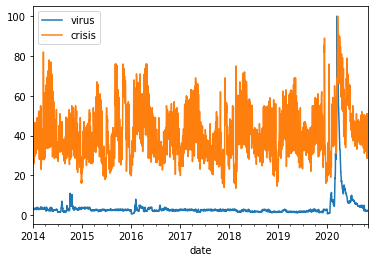

In [72]:
df_merged.plot()

In [120]:
import yfinance as yf
vix_obj = yf.Ticker("^VIX")
df_vix = vix_obj.history(period="max")
df_vix=df_vix['Close'].to_frame()
df_vix.rename(columns={'Close':'VIX'},inplace=True)

<AxesSubplot:xlabel='Date'>

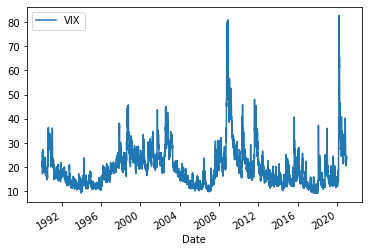

In [121]:
df_vix.plot()

In [122]:
df_vix['VIX_stat']=np.log(df_vix['VIX'])-np.log(df_vix['VIX'].shift(1))
df_trends=df_merged
df_trends=np.log(df_trends)-np.log(df_trends.shift(1))
df_trends=df_trends.shift(1)

df_vix=pd.merge(df_vix,df_trends,how='left',left_index=True,right_index=True)
df_vix.dropna(inplace=True)
df_vix.index=pd.to_datetime(df_vix.index)

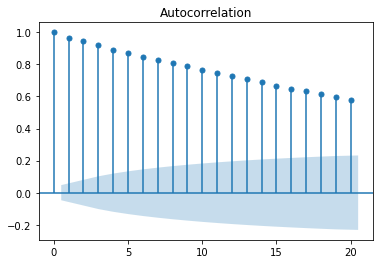

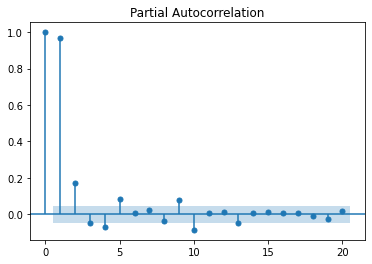

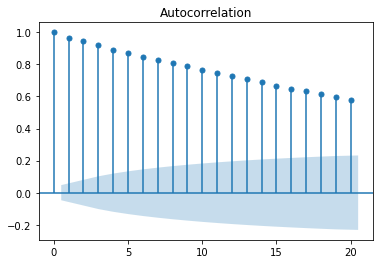

In [123]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(df_vix['VIX'], lags=20)
plot_acf(df_vix['VIX'], lags=20)

In [124]:
from statsmodels.tsa.arima.model import ARIMA
model_arma_endo=ARIMA(endog=df_vix['VIX'],order=(4,0,3)).fit()
model_arma_endo.summary()


C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programming\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                 1720
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -3526.710
Date:                Tue, 15 Dec 2020   AIC                           7071.420
Time:                        16:06:09   BIC                           7120.471
Sample:                             0   HQIC                          7089.568
                               - 1720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2086      2.489      6.915      0.000      12.331      22.086
ar.L1         -0.3383      0.155     -2.180      0.029      -0.642      -0.034
ar.L2          0.5339      0.074      7.209      0.000       0.389       0.679
ar.L3          0.4491      0.113      3.991      0.000       0.229       0.670
ar.L4          0.2756      0.104      2.656      0.008       0.072       0.479
ma.L1          1.1547      0.154      7.502      0.000       0.853       1.456
ma.L2          0.6227      0.181      3.444      0.001       0.268       0.977
ma.L3          0.3461      0.081      4.298      0.000       0.188       0.504
sigma2         3.5300      0.041     85.652      0.000       3.449       3.611
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             90743.52
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             3.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

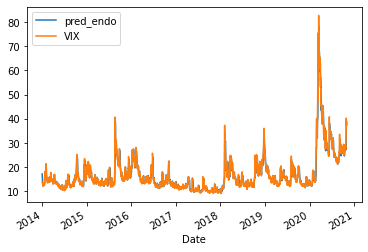

In [125]:
predictions_endo=model_arma_endo.predict()
df_vix['pred_endo']=predictions_endo
df_vix[['pred_endo','VIX']].plot()

In [126]:
model_arma_exo=ARIMA(endog=df_vix['VIX'],exog=df_vix[['crisis']],order=(4,0,3)).fit()
model_arma_exo.summary()

C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programming\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                 1720
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -3524.054
Date:                Tue, 15 Dec 2020   AIC                           7068.109
Time:                        16:06:18   BIC                           7122.609
Sample:                             0   HQIC                          7088.273
                               - 1720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9633      2.486      6.824      0.000      12.091      21.835
crisis         0.4239      0.188      2.255      0.024       0.055       0.792
ar.L1         -0.2865      0.165     -1.738      0.082      -0.609       0.037
ar.L2          0.5779      0.081      7.118      0.000       0.419       0.737
ar.L3          0.4070      0.122      3.332      0.001       0.168       0.646
ar.L4          0.2258      0.111      2.039      0.041       0.009       0.443
ma.L1          1.0994      0.164      6.694      0.000       0.777       1.421
ma.L2          0.5360      0.197      2.719      0.007       0.150       0.922
ma.L3          0.3074      0.085      3.600      0.000       0.140       0.475
sigma2         3.5186      0.045     78.669      0.000       3.431       3.606
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             88867.51
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             3.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

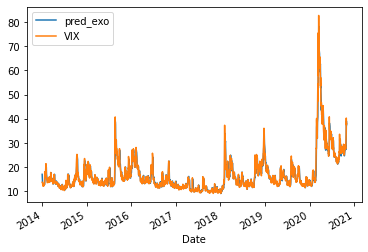

In [127]:
predictions_exo=model_arma_exo.predict()
df_vix['pred_exo']=predictions_exo
df_vix[['pred_exo','VIX']].plot()

In [128]:
print(np.mean(np.abs(df_vix['pred_endo']-df_vix['VIX'])))
print(np.mean(np.abs(df_vix['pred_exo']-df_vix['VIX'])))

1.0813744662187836
1.0785758373014032


In [137]:
from tqdm import tqdm
import dask
dask.config.set(scheduler='processes')
@dask.delayed
def compute_ARIMA_pred(df,index_insample):
    df_training=df.iloc[0:i]
    outsample=df.iloc[i]
        
    result_fit = ARIMA(endog=df_training['VIX'],order=order).fit()
    result_pred=result_fit.predict(start=len(df_training), end=len(df_training)).values[0]
    
    result.append(result_pred)
def rolling_ARMA_endo(df, window,order=(4,0,3)):
    df['pred_rolling_endo']=np.nan
    result=[]
    for i in tqdm(np.arange(window,len(df))):
        df_training=df.iloc[0:i]
        outsample=df.iloc[i]
        
        result_fit = ARIMA(endog=df_training['VIX'],order=order).fit()
        result_pred=result_fit.predict(start=len(df_training), end=len(df_training)).values[0]
        result.append(result_pred)
#         df.iloc[i]['pred_rolling_endo']=result_pred
    df.iloc[window,len(df)]['pred_rolling_endo']=result
    return df
#Trends model
def rolling_ARMA_exo(df, window, order=(4,0,3), exogenous_regressors=['crisis']):
    df['pred_rolling_exo']=np.nan
    result=[]
    for i in tqdm(np.arange(window, len(df))):
        df_training=df.iloc[0:i]
        outsample=df.iloc[i]
        
        result_fit=ARIMA(endog=df_training['VIX'],order=order,exog=df_training[exogenous_regressors]).fit()
        result_pred=result_fit.predict(start=len(df_training), end=len(df_training),exog=outsample[regressor_names]).values[0]
        df.iloc[i]['pred_rolling_endo']=result_pred
    df.iloc[window,len(df)]['pred_rolling_exo']=result
    return df

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df_vix=rolling_ARMA_endo(df_vix, 250,order=(4,0,3))
df_vix=rolling_ARMA_exo(df_vix, 250, order=(4,0,3), exogenous_regressors=['crisis'])

 57%|████████████████████████████████████████████▊                                  | 835/1470 [12:45<14:09,  1.34s/it]

In [112]:
from sklearn.metrics import mean_absolute_error
baseline_mae = mean_absolute_error(df_vix['VIX'], df_vix['pred_rolling_endo'])
trends_mae = mean_absolute_error(df_results['VIX'], df_results['pred_rolling_eexo'])
improvement = (baseline_mae-trends_mae)/baseline_mae

print(f"MAE of the baseline model: {baseline_mae*100:.2f}%")
print(f"MAE of the trends model: {trends_mae*100:.2f}%")
print(f"MAE improvement: {improvement*100:.2f}%")


C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


37.981490633360394

In [132]:
model_arma_endo.predict(start=len(df_vix)-1,end=len(df_vix)+2)

C:\Programming\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1719    37.515835
1720    37.981491
1721    36.584597
1722    36.880811
Name: predicted_mean, dtype: float64